In [1]:
import os
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import SortedNoDupeBedOverlap as bdO

import pandas as pd
import numpy as np
import csv


In [2]:
import pickle 

with open('demo_data.p', 'rb') as writer:
    data = pickle.load(writer)
mat = data['data']
id2peak = data['id2peak']


## wrong sorting: id2peak.sort(key=lambda x: x[1])

In [3]:
import pandas as pd

def ReadBedFile(fileName, skiprows = 0):
    df = pd.read_csv(fileName, sep = '\t', header = None, skiprows = skiprows)
    out = list((row[0], int(row[1]), int(row[2])) for row in zip(df[0], df[1], df[2]))
    return out

fn_bk1 = 'data/GSE97887/GSE97887_peaks_Occ1_Fcx1_Cbh1_joint_spp_RMMMcombined_RMrepeatmask100_bandwidth500_step100_thr5_span10_fdr1e-07.bed.gz'

fn_bk1_data = ReadBedFile(fn_bk1)

intersect = bdO.BedOverlap(id2peak, fn_bk1_data, 50)

id2target = ['Ex', 'In', 'Mic', 'End', 'Ast', 'Opc', 'Oli']
tmp = 'data/GSE97887/GSE97887_occ1_MAINSPLITS.%s.diffPeaks.bed.gz'
fn_target = [(c, tmp % c)  for c in id2target]

set2_ref = []


for c, f1 in fn_target:
    scan = ReadBedFile(f1, skiprows = 1)
    s2 = bdO.BedOverlap(id2peak, scan, 50)
    set2_ref.append((c, s2))
    

In [4]:
for c, s2 in set2_ref:
    break

In [11]:
id2peak[-1]

('chrY', 56836396, 56837131)

In [16]:
import scipy.stats as stats
def get_fisher_exact(s1, s2, sbk):
    
    n1 = len(s1 & s2)
    n2 = len(s1 & (sbk - s2))
    n3 = len((sbk - s1) & s2)
    n4 = len((sbk - s1) & (sbk - s2))

    mat = [[n1, n2], [n3, n4]]

    oddsratio, pvalue = stats.fisher_exact(mat, 'greater')
    return oddsratio, pvalue

In [17]:
scores = []
mat1 = data['data'].toarray()

interset = set(intersect[:,0])

for i in range (mat1.shape[1]):
    s1 = set([id2peak[j] for j in np.where(mat1[:, i] > 0.5)[0]])
    tmp = []
    for c, s2 in set2_ref:
        s2 = set(s2[:,0])
        if not (s1 & s2):
            tmp.append(0)
        else:
            tmp.append(get_fisher_exact(s1, s2, interset)[0])
    scores.append(tmp)

In [ ]:
scoresNP = np.array(scores)

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

mat = mat1.T / np.sum(mat1.T, axis = 1, keepdims=True)
clf0 = PCA(n_components = 10)
clf1 = TSNE(n_components = 2)
df_tsne = clf1.fit_transform(clf0.fit_transform(mat))

In [27]:
scoresNP.shape

(3629, 7)

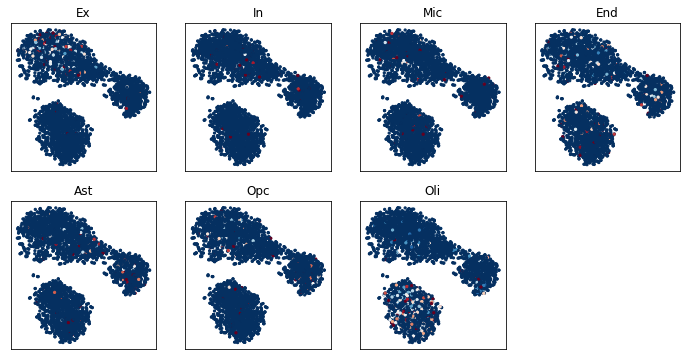

In [26]:
fig, axes = plt.subplots(2, 4, figsize = (12, 6))

for i, (c, _) in enumerate(set2_ref):
    ax = axes[i // 4, i % 4]
    vmax, vmin = np.percentile(scoresNP[:, i], 99), np.percentile(scoresNP[:, i], 1)
    ax.scatter(df_tsne[:,0], df_tsne[:,1], 
            s = 5, c = scoresNP[:, i], cmap = 'RdBu_r', vmax = vmax, vmin = vmin)
    ax.set_title(c)
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[-1, -1].axis('off')

plt.show()

In [35]:
#write output file for the intersection
IntersectFile = open(fn_bk1+'Intersection.tsv', "w+")
IntersectFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
for line in intersect: IntersectWriter.writerow(line)
IntersectFile.close()

In [36]:
#write output file for the intersection of cell types
for c, s2 in set2_ref:
    setFile = open( c+")_Intersection.tsv" , "w+")
    setFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
    setWriter= csv.writer(setFile, delimiter='\t')
    for line in s2: setWriter.writerow(line)
    setFile.close()
    

In [ ]:
#write output file for fischer exact scores
ScoreFile = open('DatafischerScores.tsv', "w+")
ScoreFile.write("Ex\tIn\tMic\tEnd\tAst\tOpc\tOli\n")
IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
for line in intersect: IntersectWriter.writerow(line)
sFile.close()
